In [93]:

import scipy
#import pytrends
#from pytrends.request import TrendReq
from numpy import random
import matplotlib.pyplot as plt
from scipy import optimize
import sys
import time
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
from datetime import datetime, timedelta
from county_spending import get_county_spending, spend_county_state_map, us_state_abbrev, abbrev_us_state, geo_search
from ACS_data import colname_mask
import re
import pickle
import requests
import copy
import censusdata
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy

import statsmodels.api as sm

import plotly.express as px


In [4]:
g = censusdata.censusgeo([('state', '*'), ('county', '*')])

In [58]:
df = pd.read_csv('merged_df.csv')
df = df.loc[:,['county_name','State','per_capita', 'population']]

In [150]:
def get_data_by_subject(subject, topx=50, acs='acs5', year=2019, g=g):
    
    search = censusdata.search('acs1', year, 'concept', subject)#[:topx]
    var_list = [i[0] for i in search]
    var_names = [i[1]+i[2] for i in search]
    # Using ACS5 here for completeness sake, will always assume to left merge at a later date
    tmp_df = censusdata.download(acs, year, g, var_list, key=None, tabletype='detail', endpt='')
    rename = dict(zip(tmp_df.columns, var_names))
    tmp_df = tmp_df.rename(columns =rename)
    tmp_df = tmp_df.reset_index()
    tmp_df['county_name'] = tmp_df['index'].apply(lambda x: str(x).split(':')[0].split(',')[0])
    tmp_df['State'] = tmp_df['index'].apply(lambda x: str(x).split(':')[0].split(',')[1][1:])
    tmp_df['State'] = tmp_df['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
    tmp_df = tmp_df.drop(columns=['index'])
    
    
    return tmp_df

def get_data_by_varlist(varlist, acs='acs5', year=2019, g=g):
    
    var_list = varlist
    #var_names = [i[1]+i[2] for i in search]
    tmp_df = censusdata.download(acs, year, g, var_list, key=None, tabletype='detail', endpt='')
    rename = dict(zip(tmp_df.columns, var_list))
    tmp_df = tmp_df.rename(columns =rename)
    tmp_df = tmp_df.reset_index()
    tmp_df['county_name'] = tmp_df['index'].apply(lambda x: str(x).split(':')[0].split(',')[0])
    tmp_df['State'] = tmp_df['index'].apply(lambda x: str(x).split(':')[0].split(',')[1][1:])
    tmp_df['State'] = tmp_df['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
    tmp_df = tmp_df.drop(columns=['index'])
    
    return tmp_df

def explore_plots(plots_df,df=df):
    joined = df.merge(plots_df, how='left', on=['county_name','State'])
    for i in joined.columns:
        if i not in ['county_name', 'State', 'per_capita']:
            y = np.log(joined[i].astype(float))
            x = np.log(joined['per_capita'])
            plt.scatter(x,y)
            plt.title(i)
            plt.show()
            
def get_proba(col_name, joined=joined):
    model = KernelDensity(bandwidth=1, kernel='gaussian')
    sample = np.array(np.log(joined[col_name]+0.00000001))
    sample = np.array([np.nanmean(sample) if np.isnan(i) else i for i in sample])
    sample = sample.reshape((len(sample), 1))
    model.fit(sample)
    values = np.linspace(0, max(sample)[0], 100)
    values = values.reshape((len(values), 1))
    probabilities = model.score_samples(values)
    probabilities = np.exp(probabilities)
    return probabilities

def get_KL(col_name, joined=joined):
    pop = get_proba('population')
    col = get_proba(col_name)
    KL = entropy(pk=pop, qk=col)
    return KL
    

In [88]:
topics_list = ['industry', 'race', 'computer', 'poverty', 'educaction', 'health']

variable_list = []

def search_acs(subject):
    search = censusdata.search('acs5', 2019, 'concept', subject)
    var_list = [i[0] for i in search]
    var_names = [i[1]+i[2] for i in search]
    return var_list

for i in topics_list:
    tmp = search_acs(i)
    variable_list+=tmp


In [153]:
any(np.isnan(joined['B08526_001E']))

True

In [148]:
get_KL('B08526_001E', joined=joined)

0
0


0.060530829024014216

In [151]:
%%time
KL_list = []
new_varlist = []
#df = pd.read_csv('merged_df.csv')
#print('Starting census query')
#tmp_df = get_data_by_varlist(variable_list)
#print('Census query complete')
#joined = df.merge(tmp_df, how='left', on=['county_name', 'State'])
for j in joined.columns[32:]:
    if j not in ['county_name', 'State', 'per_capita', 'Unnamed: 0']:
        if type(joined[j])!=str:
            try:
                new_varlist.append(j)
                KL_list.append(get_KL(j, joined=joined))
            except ValueError as e:
                print(j)
                continue

KL_df = pd.DataFrame({'KL_Divergence':KL_list,
                     'variable_code':new_varlist})


/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hank/miniconda3/envs/mle

TypeError: can only concatenate str (not "float") to str

In [152]:
KL_df.sort_values('KL_Divergence')

NameError: name 'KL_df' is not defined

In [ ]:
def identify_outlier_counties(joined):
    

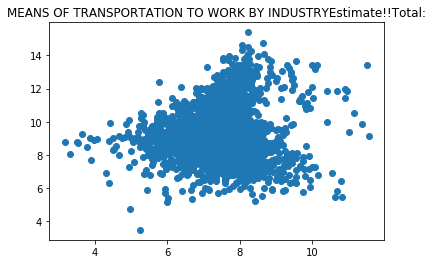

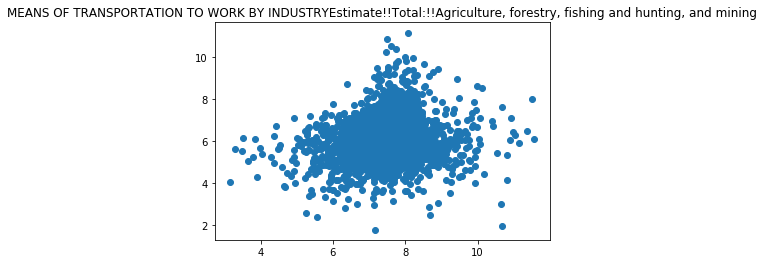

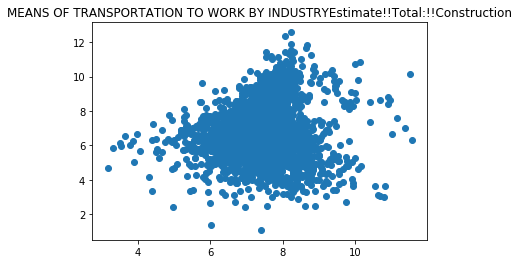

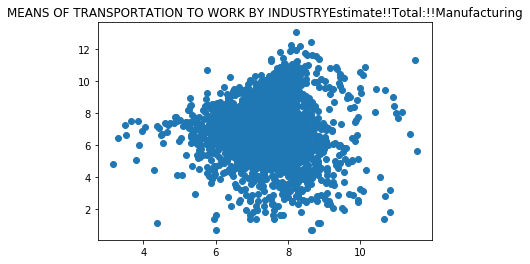

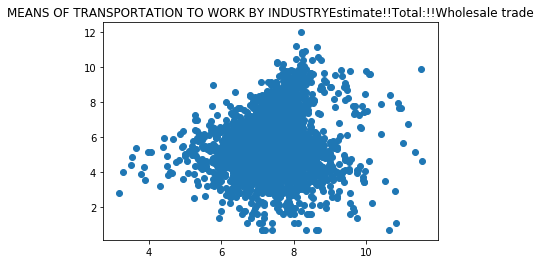

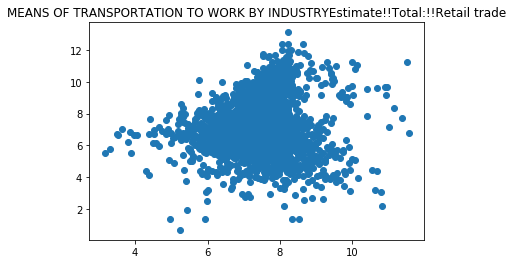

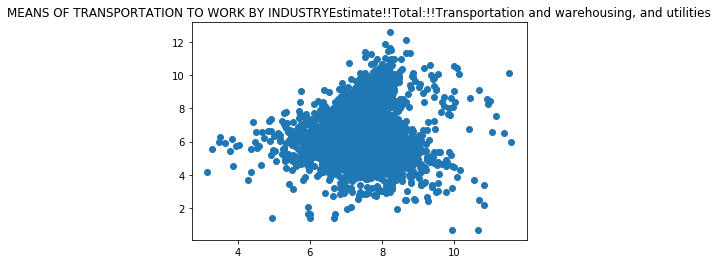

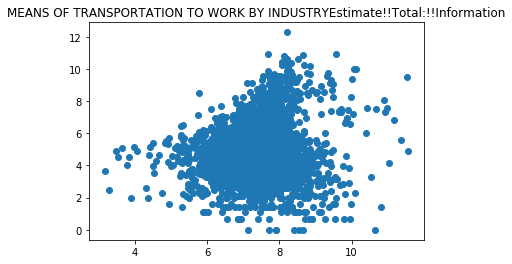

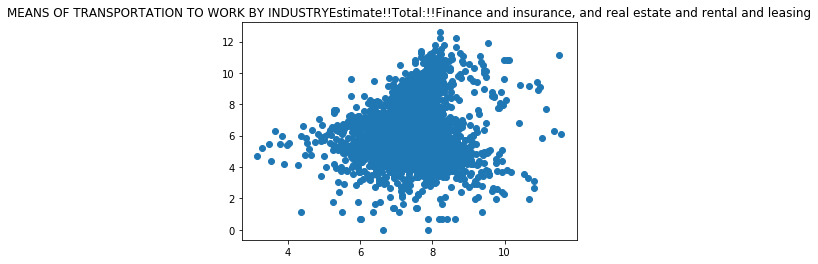

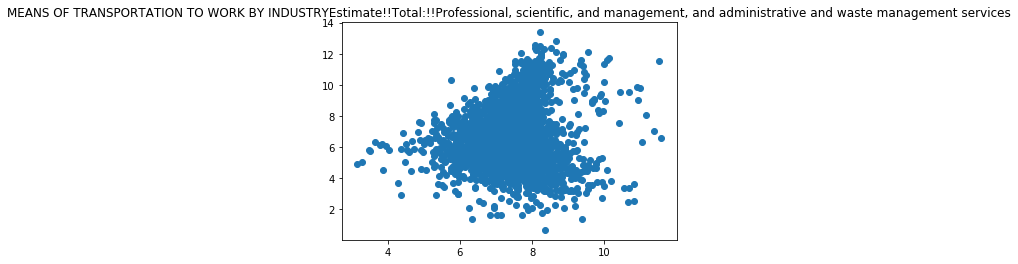

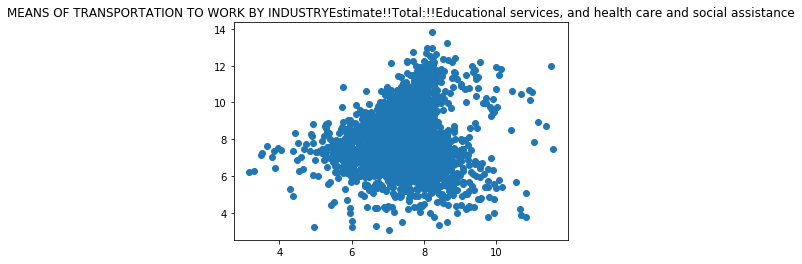

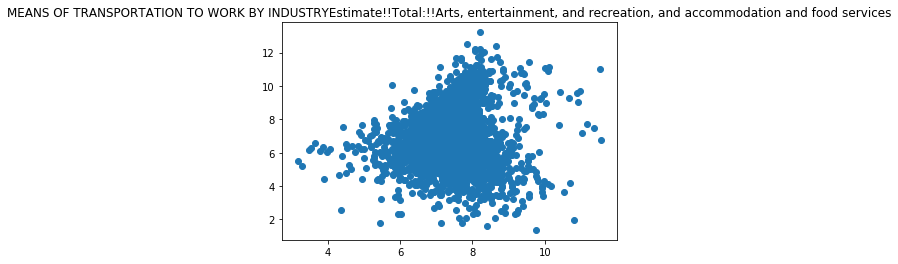

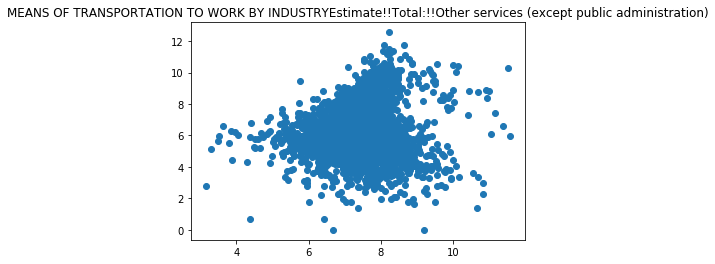

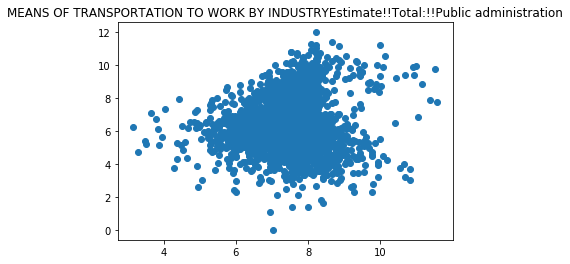

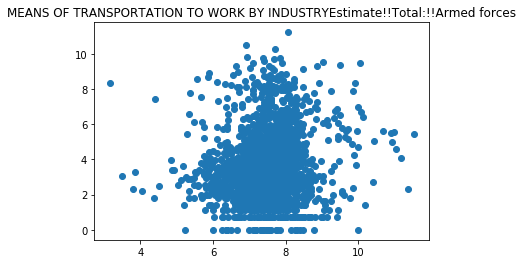

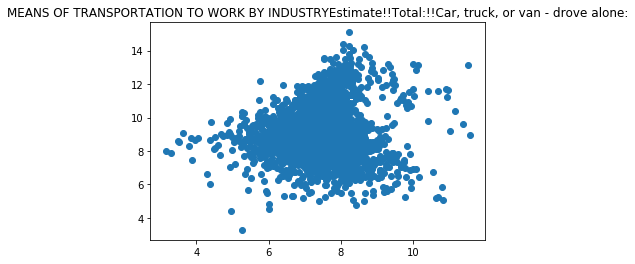

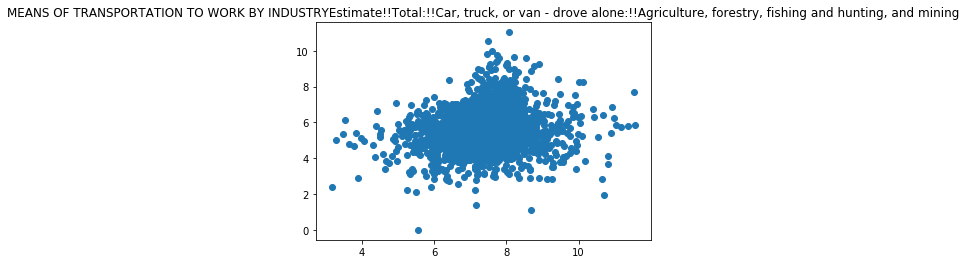

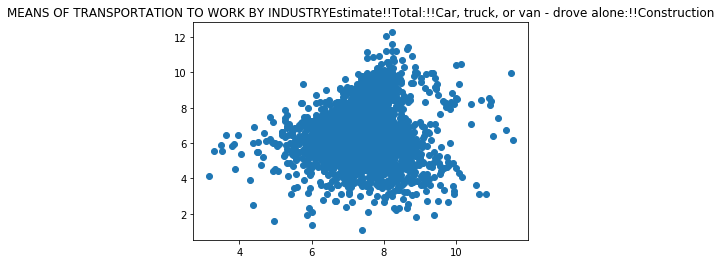

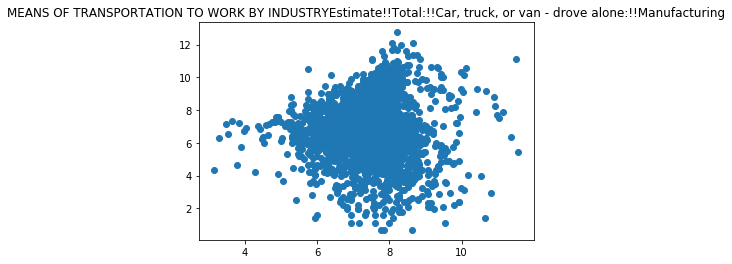

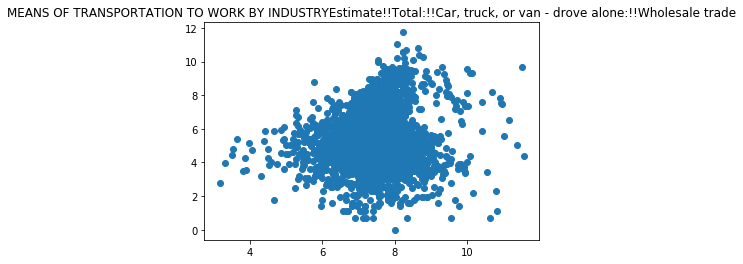

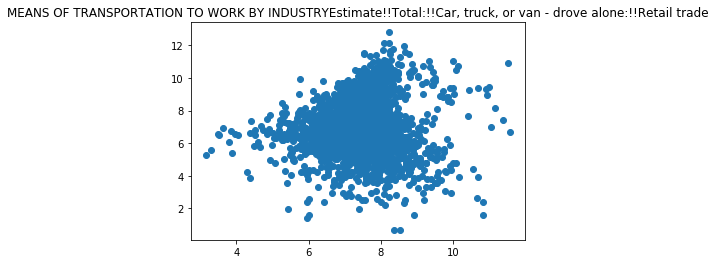

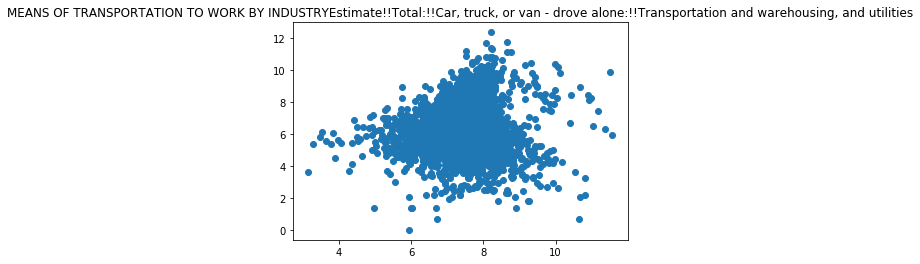

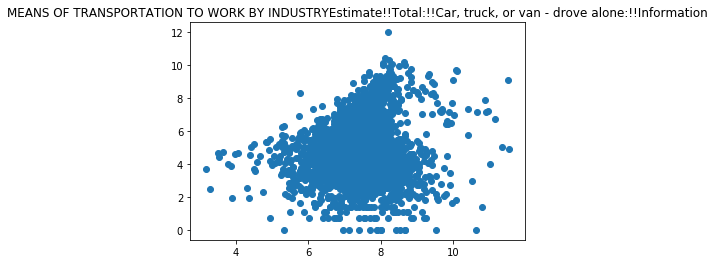

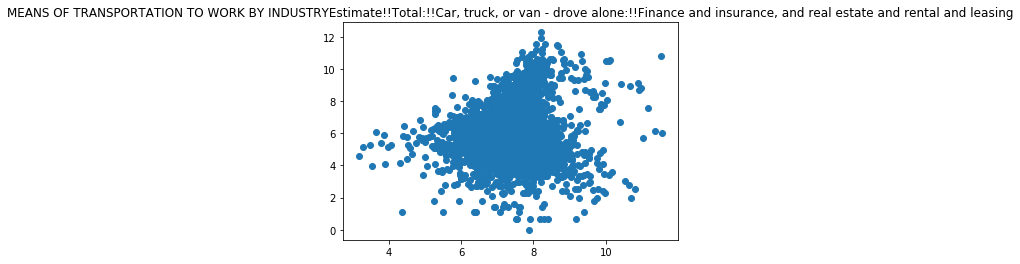

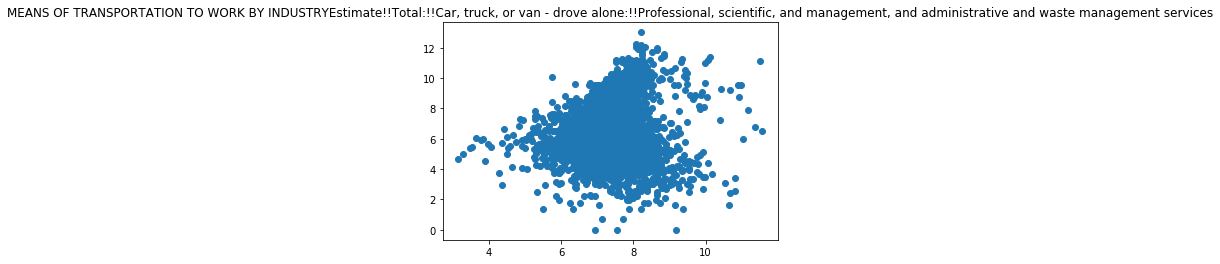

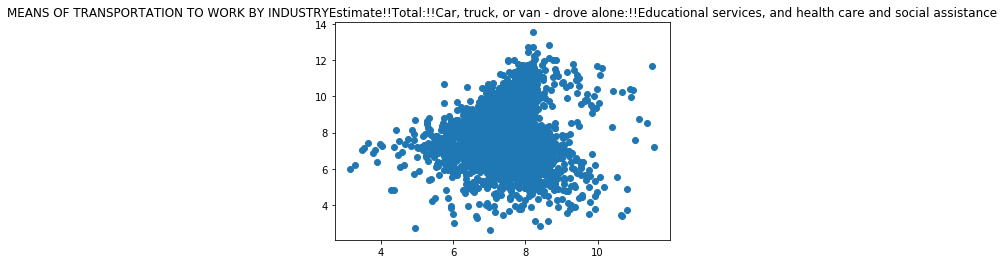

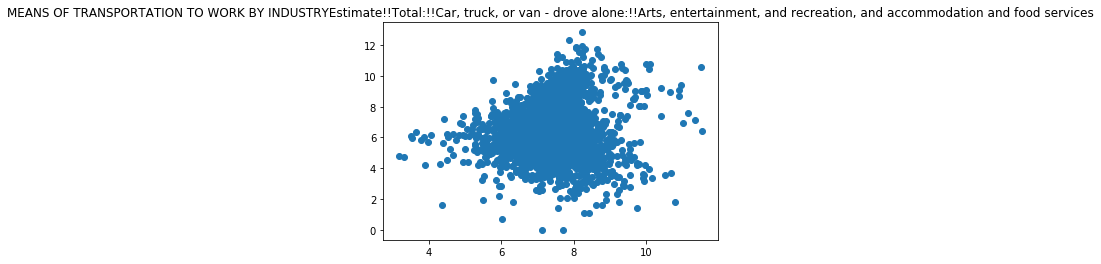

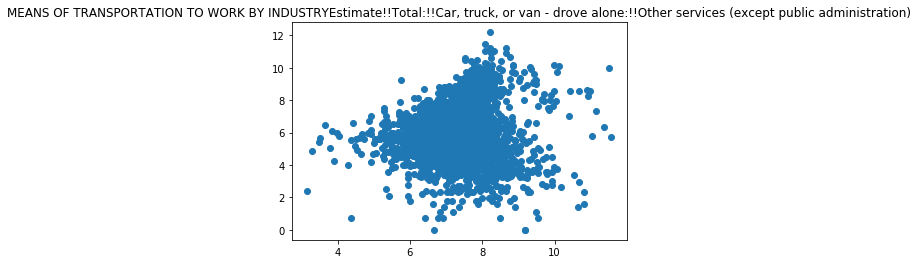

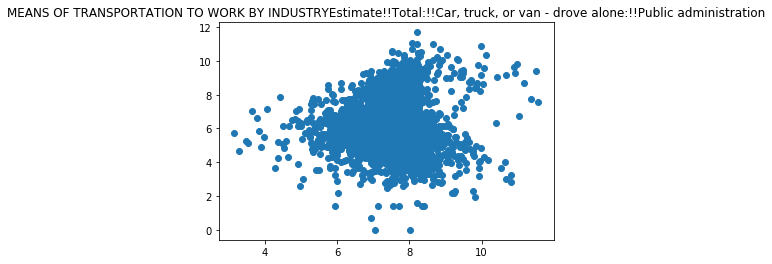

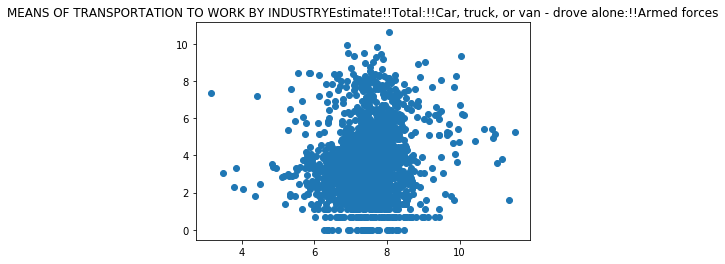

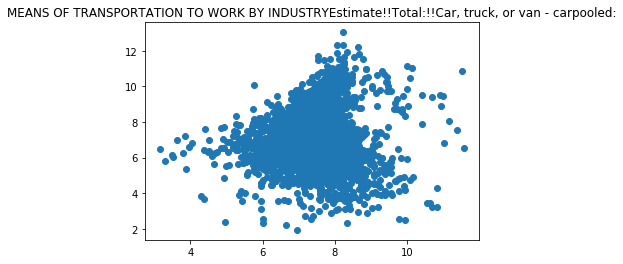

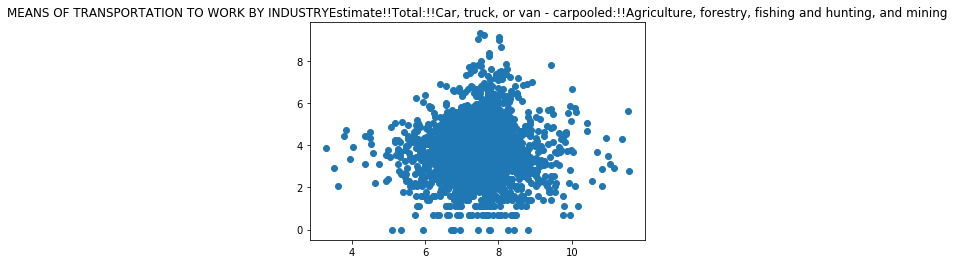

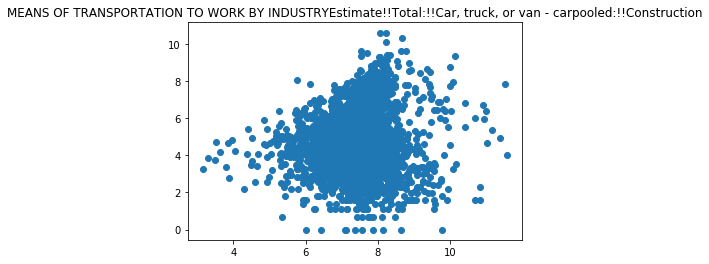

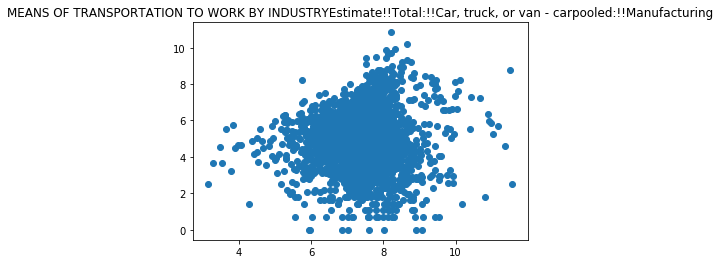

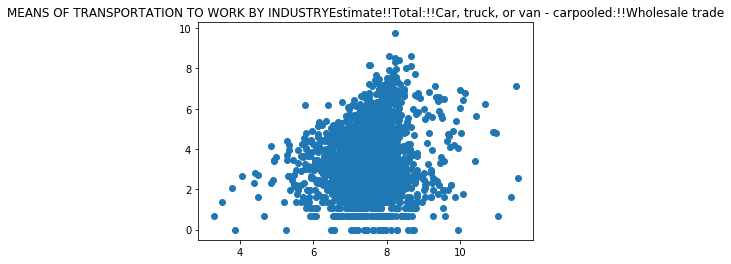

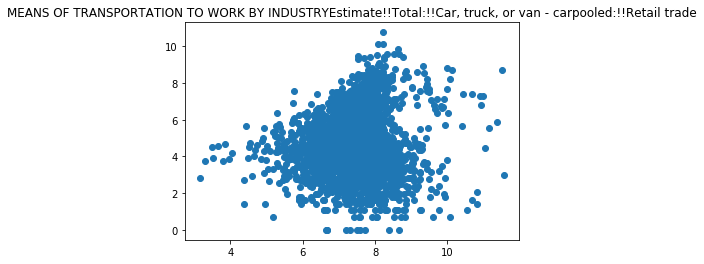

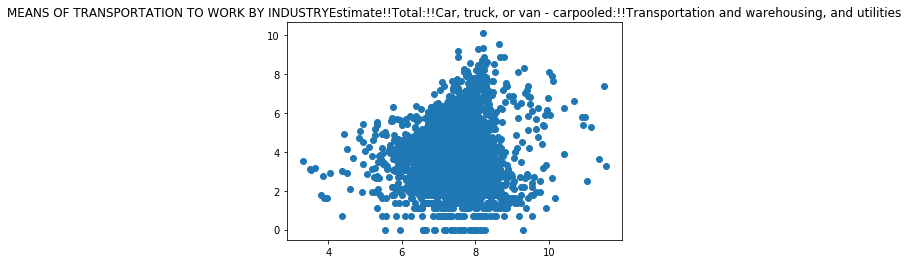

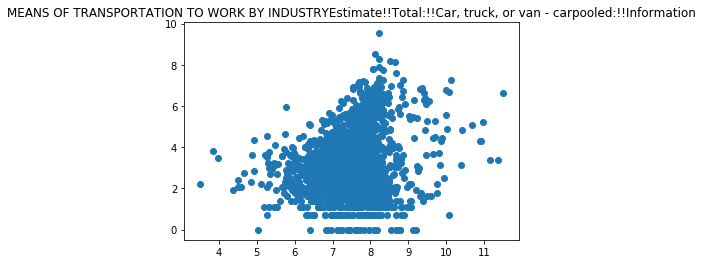

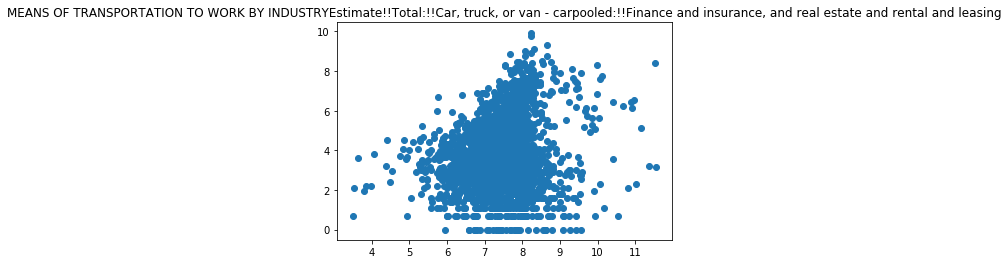

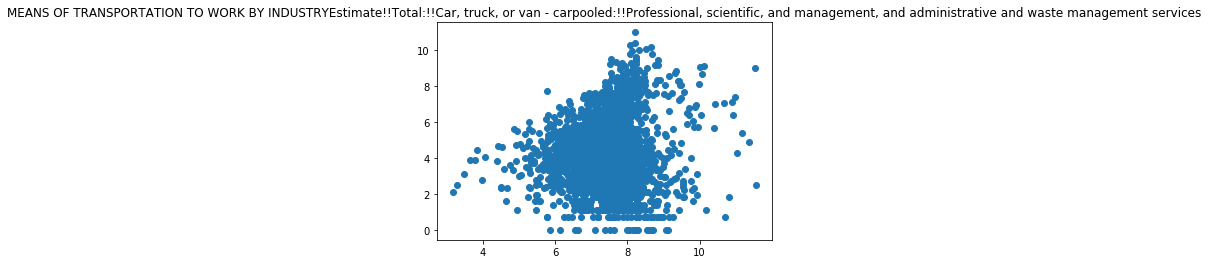

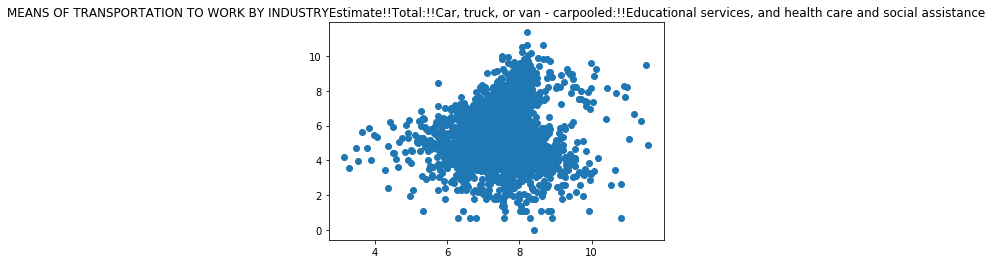

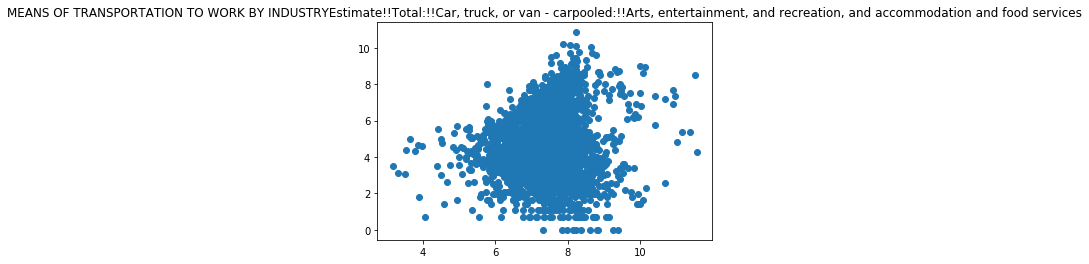

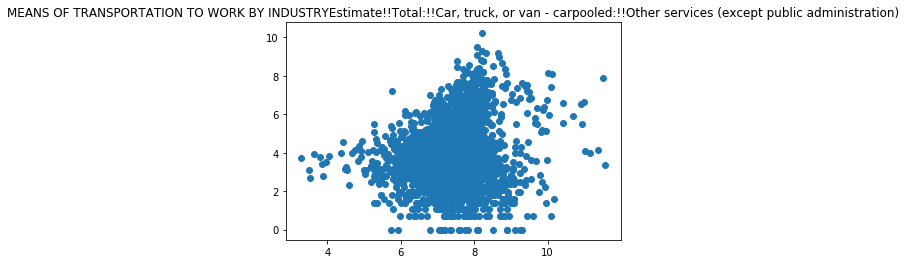

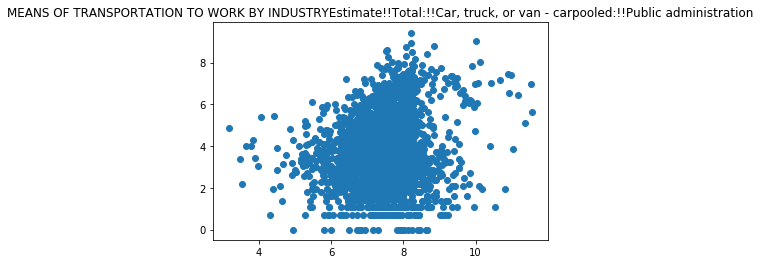

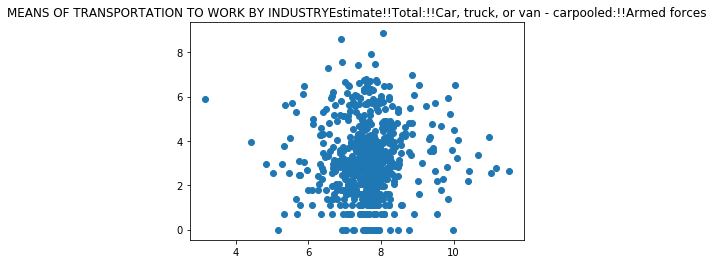

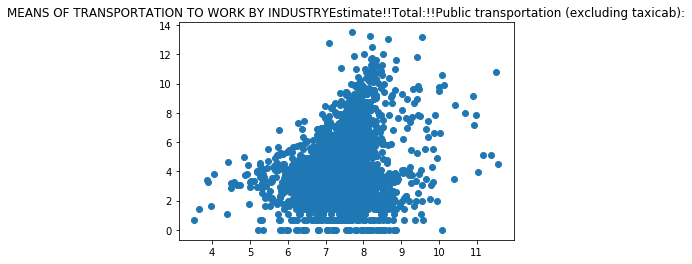

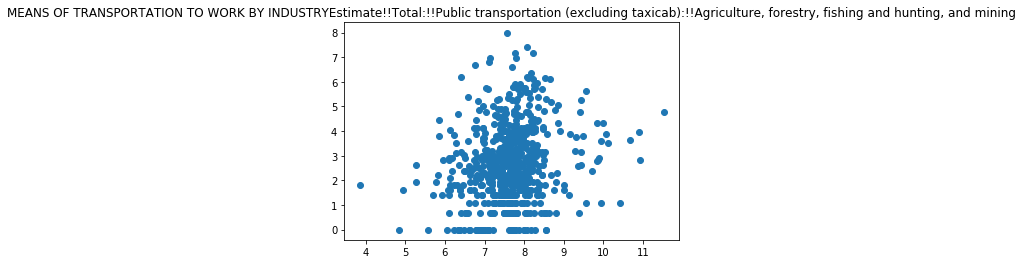

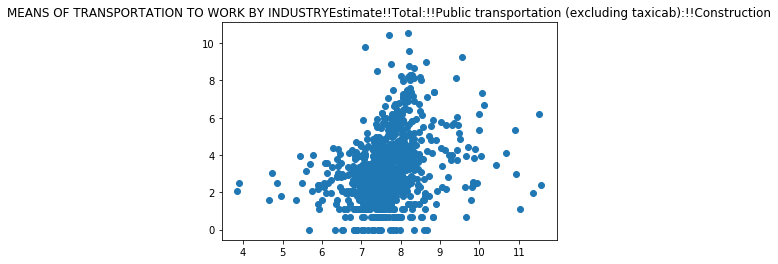

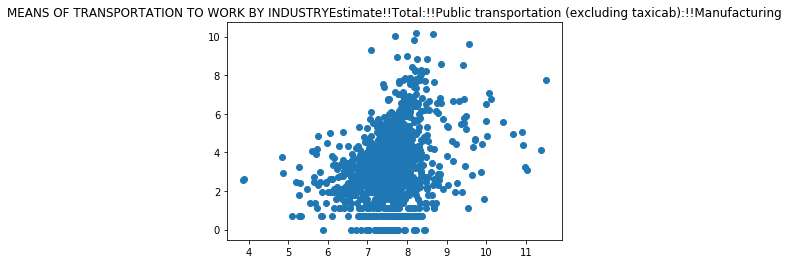

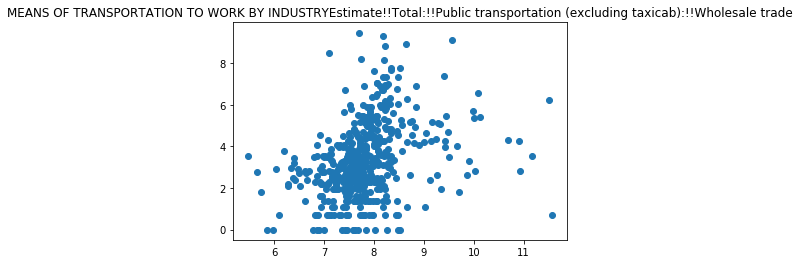

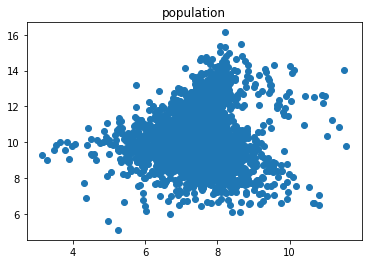

In [24]:
explore_plots(my_df)